# Denoising Diffusion Probabilistic Models

In this notebook, we'll implement the Denoising Diffusion Probabilistic Model (DDPM) proposed in the paper [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) from scratch using PyTorch. We'll implement the U-Net model, the forward and reverse diffusion processes, the training loop and the sampling process.

In [177]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import math
import numpy as np


## UNet
At the heart of DDPMs is the U-Net model. The U-Net is a symmetrical architecture with an encoder (left) and decoder (right) path. It takes in a noisy image and predicts the amount of noise that was added to it. 

In the denoising process, the U-Net takes in the noisy image and the timestep and predicts the amount of noise that was added to it. We can then use this prediction to denoise the image by subtracting the predicted noise from the noisy image. In this manner, we gradually transform the noisy image to a clear image. 

We split the U-net into 3 blocks, Left, Middle and Right.

At the root of it all is the conv block. Each layer in the left and the right blocks consists of a series of ConvBlocks followed by a maxpool or an upsample. 

The convblocks are resnets with group normalization and are imported from src.resnet.py. We changed the original resnets to accept "timestep embeddings" that we'll explore later. 


### Changes that need to be made to a regular [U-Net](https://arxiv.org/abs/1505.04597) for DDPM:


1. Swap batch norm with group norm 
2. Introduce an attention mechanism at each conv block in the down and up blocks
3. Create an embedding for the timestep
4. Develop a 2D attention mechanism based on the one used in the text transformer model in [aryamanpandya99/transformers](https://github.com/aryamanpandya99/transformers)


## ConvBlock Illustrated

The ConvBlock is a resnet with group normalization followed by a 2D multihead attention. We can set the number of resblocks in the ConvBlock as a parameter. 

# <img src="images/convblock.png" alt="ConvBlock Illustrated" width="50%"/>


In [178]:
from src.resnet import ResBlock


class ConvBlock(nn.Module):
    def __init__(
            self, 
            in_channels: int, 
            out_channels: int, 
            num_layers: int, 
            num_groups: int = 1, 
            dropout: float = 0.2, 
            activation: nn.Module = nn.ReLU,
            timestep_emb_dim: int = None
        ):
        super(ConvBlock, self).__init__()
        convs = []
        convs.append(
            ResBlock(
                in_channels, 
                out_channels, 
                num_groups=num_groups, 
                dropout=dropout, 
                activation=activation,
                timestep_emb_dim=timestep_emb_dim
            )
        )
        
        for _ in range(num_layers-1):
            convs.append(
                ResBlock(
                    out_channels,
                    out_channels, 
                    num_groups=num_groups, 
                    dropout=dropout, 
                    activation=activation,
                    timestep_emb_dim=timestep_emb_dim
                )
            )

        self.convs = nn.ModuleList(convs)

    def forward(self, x, timestep_emb=None):
        for res_block in self.convs:
            x = res_block(x, timestep_emb)
        
        return x

## Changes to the attention mechanism from Attention is all you need

- we no longer need a d_model, the internal hidden size is determined by the number of channels which is determined by the convolutional layers leading up to the attention layer.

- swap batch norm with group norm

- we resize the image to one of shape: (batch_size, num_channels, height * width) so that we can perform multihead attention across the image. This closely mirrors (batch_size, embed_dim, seq_len)


In [182]:
def scaled_dot_product_attention(q, k, d_k, mask):
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is True:
        mask = torch.tril(torch.ones(scores.shape)).to(q.device)
        scores = scores.masked_fill(mask == 0, float('-inf'))
    return nn.Softmax(-1)(scores)

class Attention(nn.Module):
    """
    Multihead attention.
    """
    def __init__(self,
                 dropout: float, 
                 num_heads: int, 
                 num_channels: int,
                 num_groups: int = 8,
                 d_k: int = None, 
                 mask: bool = False
                 ):
        super(Attention, self).__init__()
        self.d_k, self.num_heads = d_k, num_heads
        
        if self.d_k is None:
            self.d_k = num_channels 

        self.query_projection, self.key_projection, self.value_projection = (
            nn.Linear(num_channels, num_heads * self.d_k),
            nn.Linear(num_channels, num_heads * self.d_k), 
            nn.Linear(num_channels, num_heads * self.d_k)
        )
        self.group_norm = nn.GroupNorm(
            num_groups=num_groups, 
            num_channels=num_channels
        )
        self.output_layer = nn.Linear(num_heads * self.d_k, num_channels)
        self.dropout = nn.Dropout(dropout)
        self.mask = mask
        self.num_channels = num_channels

    def forward(self, x, y = None):
        """
        Forward pass of the attention layer.
        """
        batch_size, n_channels, height, width = x.shape
        x = self.group_norm(x)
        x = x.view(batch_size, n_channels, height * width).permute(0, 2, 1)
        
        residual = x

        if y is not None:
            k, q, v = y, x, y
        else:
            k, q, v = x, x, x
        
        k_len, q_len, v_len, batch_size = k.size(1), q.size(1), v.size(1),  q.size(0)
        
        k = self.key_projection(k).view(batch_size, k_len,  self.num_heads, self.d_k)
        q = self.query_projection(q).view(batch_size, q_len,  self.num_heads, self.d_k)
        v = self.value_projection(v).view(batch_size, v_len,  self.num_heads, self.d_k)
        
        attention = scaled_dot_product_attention(
            q.transpose(1, 2), 
            k.transpose(1, 2), 
            self.d_k, 
            self.mask
        )
        output = torch.matmul(attention, v.transpose(1, 2))
        output = self.output_layer(output.transpose(1, 2).contiguous().view(batch_size, q_len, -1))

        h = self.dropout(output) + residual

        h = h.permute(0, 2, 1).view(batch_size, n_channels, height, width)
        
        return h


In [183]:
example_image = torch.randn(2, 3, 128, 128)
conv_block = ConvBlock(3, 32, 2)
h_example_image = conv_block(example_image)

In [184]:
attention_block = Attention(d_k=64, dropout=0.1, num_heads=3, num_channels=32, num_groups=8)
attn_output = attention_block(h_example_image)
attn_output.shape

torch.Size([2, 32, 128, 128])

# Timestep Encoding and Embedding

TODO: Explain

In [185]:
def timestep_encoding(curr_t: torch.Tensor, T: torch.Tensor, embedding_dim: int, n=10000, device: torch.device = "cpu"):
    """
    Naive sin/cosin positional embedding adapted for timestep embedding in DDPM
    """
    curr_t = curr_t / T # normalize the timestep to be between 0 and 1
    p = torch.zeros((curr_t.shape[-1], embedding_dim)).to(device) # initialize the positional embedding tensor

    m = torch.arange(int(embedding_dim/2)).to(device) # this is divided by two because we alternate between sin and cos
    denominators = torch.pow(n, (2*m/embedding_dim))  # compute the denominators for the sin and cos functions
    
    p[:, 0::2] = torch.sin(curr_t.unsqueeze(1) / denominators.unsqueeze(0))
    p[:, 1::2] = torch.cos(curr_t.unsqueeze(1) / denominators.unsqueeze(0))
    return p



class TimestepEmbedding(nn.Module):
    """
    Embeds the timestep into a higher dimensional space using a 2 layer MLP.
    """
    def __init__(self,
                in_channels: int, 
                embedding_dim: int, 
                activation: nn.Module = nn.ReLU
                ):
        """
        Args:
            in_channels: number of input channels
            embedding_dim: dimension of the embedding space
            activation: activation function
        """
        super(TimestepEmbedding, self).__init__()
        self.linear1 = nn.Linear(in_channels, embedding_dim)
        self.linear2 = nn.Linear(embedding_dim, embedding_dim)
        self.activation = activation()

    def forward(self, curr_t: torch.Tensor, T: torch.Tensor):
        x = self.linear1(curr_t)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        
        return x

## UNet Illustrated

I found that there weren't too many good illustrations of the specific UNet architecture used in DDPMs, so I decided to make my own. Hopefully this helps someone understand how UNets are implemented for diffusion, or at least understand my specific implementation better. 

This UNet is built off of the ConvBlocks and the TimestepEmbedding that we defined earlier. 

# <img src="images/ddpm_unet_illustrated.png" alt="UNet Illustrated" width="50%"/>



In [186]:
class LeftBlock(nn.Module):
    """
    Downampling (left) side of the UNet.
    Excludes the bottom-most conv block.
    """
    def __init__(
            self, 
            in_channels: int, 
            filters: list[int], 
            num_layers: int, 
            has_attention: list[bool] = [False, True, False], 
            num_heads: int = 8, 
            dropout: float = 0.2, 
            timestep_emb_dim: int = None
            ):
        super(LeftBlock, self).__init__()
        
        self.has_attention = has_attention
        conv_blocks = [ConvBlock(in_channels, filters[0], num_layers, timestep_emb_dim=timestep_emb_dim, dropout=dropout)]
        attention_blocks = [
            Attention(
                dropout=dropout, 
                num_heads=num_heads, 
                num_channels=filters[0], 
            )
        ] if has_attention else []
        
        for i in range(1, len(filters)):
            conv_blocks.append(ConvBlock(filters[i-1], filters[i], num_layers, timestep_emb_dim=timestep_emb_dim, dropout=dropout))
            if has_attention[i]:
                attention_blocks.append(
                    Attention(
                        d_k=64, 
                        dropout=dropout, 
                        num_heads=num_heads, 
                        num_channels=filters[i], 
                    )
                )
            else:
                attention_blocks.append(None)
        
        self.conv_blocks = nn.ModuleList(conv_blocks)
        self.attention_blocks = nn.ModuleList(attention_blocks)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x, timestep_emb=None):
        residual_outputs = []
        for i, conv_block in enumerate(self.conv_blocks):
            x = conv_block(x, timestep_emb)
            if self.has_attention[i]:
                x = self.attention_blocks[i](x)
            
            residual_outputs.append(x)
            x = self.maxpool(x)

        return residual_outputs, x


class RightBlock(nn.Module):
    """
    Upsampling (right) side of the UNet.
    """
    def __init__(
            self, 
            filters: list[int], 
            num_layers: int, 
            has_attention: list[bool] = [False, True, False], 
            num_heads: int = 8, 
            dropout: float = 0.2,
            timestep_emb_dim: int = None,
            ):
        super(RightBlock, self).__init__()
        self.has_attention = has_attention

        conv_layers = []
        upsample_layers = []
        attention_layers = []

        for i in range(len(filters) - 1):
            conv_layers.append(
                ConvBlock(filters[i], filters[i+1], num_layers, timestep_emb_dim=timestep_emb_dim, dropout=dropout)
            )
            upsample_layers.append(
                nn.ConvTranspose2d(filters[i+1], filters[i+1]//2, 2, stride=2)
            )

            if has_attention[i]:
                attention_layers.append(
                    Attention(dropout=dropout, num_heads=num_heads, num_channels=filters[i+1]//2)
                )
            else:
                attention_layers.append(None)
        
        conv_layers.append(
            ConvBlock(filters[-1], filters[-1]//2, num_layers, timestep_emb_dim=timestep_emb_dim, dropout=dropout)
        )
        self.conv_layers = nn.ModuleList(conv_layers)
        self.attention_layers = nn.ModuleList(attention_layers)
        self.upsample_layers = nn.ModuleList(upsample_layers)
    
    def forward(self, x, residual_outputs, timestep_emb=None):
        for i in range(len(self.conv_layers)):
            residual = residual_outputs[-(i+1)]
            _, _, h, w = x.shape
            residual = residual[:, :, :h, :w]

            x = torch.cat([x, residual], dim=1)
            x = self.conv_layers[i](x, timestep_emb)



            if i < len(self.upsample_layers):
                x = self.upsample_layers[i](x)
                if self.has_attention[i]:
                    x = self.attention_layers[i](x)
        return x


In [187]:
db = LeftBlock(in_channels=3, filters=[32, 64, 128, 256], num_layers=2, has_attention=[True, True, False, False], num_heads=3, timestep_emb_dim=128)

In [188]:
timesteps = torch.randint(0, 1000, (2,))
t_encoded = timestep_encoding(timesteps, 1000, 32)
t_encoded.shape # N x 32

time_embedding_layer = TimestepEmbedding(in_channels=32, embedding_dim=128, activation=nn.ReLU) # N x 32 -> N x 128 (embedding_dim)
t_embedded = time_embedding_layer(curr_t=t_encoded, T=1000)

In [189]:
a = db(torch.randn(2, 3, 128, 128), timestep_emb=t_embedded)
a[1].shape

torch.Size([2, 256, 8, 8])

In [190]:
for residual_output in a[0]:
    print(residual_output.shape)
    print("-"*10)

print(a[1].shape)

torch.Size([2, 32, 128, 128])
----------
torch.Size([2, 64, 64, 64])
----------
torch.Size([2, 128, 32, 32])
----------
torch.Size([2, 256, 16, 16])
----------
torch.Size([2, 256, 8, 8])


In [191]:
bottom_conv = nn.Sequential(ResBlock(256, 512), nn.ConvTranspose2d(512, 256, 2, stride=2))
bottom_conv(a[1]).shape

torch.Size([2, 256, 16, 16])

In [192]:
up = RightBlock(filters=[512, 256, 128, 64], num_layers=2, has_attention=[True, True, False, False, False], num_heads=3, timestep_emb_dim=128)

In [193]:
bottom_out = bottom_conv(a[1])
bottom_out.shape


torch.Size([2, 256, 16, 16])

In [194]:
up_out = up(bottom_out, a[0], t_embedded)
up_out.shape

torch.Size([2, 32, 128, 128])

In [195]:
class UNet(nn.Module):
    """
    UNet model for DDPM.
    """
    def __init__(self,
                 down_filters: list[int], 
                 in_channels: int, 
                 num_layers: int, 
                 has_attention: list[bool] = [False, True, False], 
                 num_heads: int = 8,
                 diffusion_steps: int = None,
                 num_groups: int = 8,
                 activation: nn.Module = nn.ReLU,
                 dropout: float = 0.1
                ):
        super(UNet, self).__init__()
        self.T = diffusion_steps
        self.down_filters = down_filters
        self.up_filters = [x*2 for x in reversed(down_filters)]
        self.num_groups = num_groups
        self.activation = activation()
        self.dropout = dropout

        self.time_embed_dim = down_filters[0] * 4 
        self.num_layers = num_layers
        
        if self.T is not None:
            self.timestep_embedding = TimestepEmbedding(
                in_channels=self.down_filters[0], 
                embedding_dim=self.time_embed_dim, 
                activation=activation, 
            )
        
        
        self.left_block = LeftBlock(
            filters=down_filters, 
            num_layers=num_layers, 
            in_channels=in_channels, 
            has_attention=has_attention, 
            num_heads=num_heads,
            dropout=dropout,
            timestep_emb_dim=self.time_embed_dim  # Add this line
        )
        
        # the bottom-most (middle) conv block 

        self.middle_conv = ConvBlock(
            down_filters[-1], 
            down_filters[-1]*2, 
            num_layers, 
            timestep_emb_dim=self.time_embed_dim  
        )
        self.middle_attention = Attention(d_k=64, dropout=0.1, num_heads=num_heads, num_channels=down_filters[-1]*2)
        self.middle_upsample = nn.ConvTranspose2d(down_filters[-1]*2, down_filters[-1], 2, stride=2)
        
        self.right_block = RightBlock(
            filters=self.up_filters, 
            num_layers=num_layers, 
            has_attention=has_attention, 
            num_heads=num_heads,
            dropout=dropout,
            timestep_emb_dim=self.time_embed_dim 
        )
        
        first_group = num_groups if in_channels > num_groups else in_channels
        self.group_norm = nn.GroupNorm(num_groups=first_group, num_channels=in_channels)  # Change this line

        self.group_norm2 = nn.GroupNorm(num_groups=num_groups, num_channels=down_filters[0])
        
        self.conv_out = nn.Conv2d(in_channels=down_filters[0], out_channels=in_channels, kernel_size=3, padding=1)
    
    def forward(self, x, t):
        if self.T is not None:
            t_encoded = timestep_encoding(t, self.T, self.down_filters[0], n = 4000, device=x.device)
            t_emb = self.timestep_embedding(curr_t=t_encoded, T=self.T)
            
            t_emb = t_emb.view(-1, self.time_embed_dim)
        else: 
            t_emb = None

        h = self.group_norm(x)
        
        res, h = self.left_block(h, t_emb)
        
        h = self.middle_conv(h, t_emb)
        h = self.middle_attention(h)
        
        h = self.middle_upsample(h)
        h = self.right_block(h, res, t_emb)
        
        h = self.activation(self.group_norm2(h))
        output = self.conv_out(h)
        return output


In [196]:
u_net = UNet(down_filters=[32, 64, 128], in_channels=3, num_layers=2, has_attention=[True, True, False], num_heads=3, diffusion_steps=1000)


In [197]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(u_net)
print(f"The UNet model has {num_params:,} trainable parameters.")


The UNet model has 4,499,599 trainable parameters.


In [198]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

sample_inputs = torch.randn(16, 3, 32, 32).to(device)
u_net.to(device)
sample_outputs = u_net(sample_inputs, torch.randint(0, 1000, (16,)).to(device))
sample_outputs.shape

torch.Size([16, 3, 32, 32])

## DDPM Training Procedure

In [199]:
def get_alpha_bar(beta_schedule: torch.Tensor):
    """
    what we need to do here is prepare a tensor of alpha_bars where each t'th entry
    in alphabars is the product of the alphas leading up to it. Alpha is  as 1 - beta
    """
    alpha = 1. - beta_schedule
    return alpha.cumprod(dim=0)

def prepare_batch(x: torch.Tensor, T: int, alpha_bar: torch.Tensor):
    """
    Prepare a batch for training by generating random timesteps and adding noise to the image.
    We use the random timesteps to generate the amount of noise that should be added to the image at that timestep.
    Then, we add the noise to the image.
    
    Args:
        x: the input image
        T: the number of diffusion steps
        beta_schedule: the beta values for each timestep
    
    Returns:
        the noisy image and the timestep 
        the noise that was added to the image
    """
    t = torch.randint(0, T, (x.shape[0],), requires_grad=False).to(x.device)
    e = torch.randn_like(x, requires_grad=False).to(x.device)
    
    alpha_bar_t = alpha_bar[t].view(-1, 1, 1, 1)
    noisy_images = (alpha_bar_t.sqrt() * x) + ((1 - alpha_bar_t).sqrt() * e)
    
    return (noisy_images, t), e

## Data


In [200]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

# Define the transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize((0.1307,), (0.3081,)),  # MNIST normalization
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
valid_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size=512, shuffle=True)
valid_dl = DataLoader(valid_dataset, batch_size=512, shuffle=False)

# Move data to device
train_dl = [(x.to(device), y.to(device)) for x, y in train_dl]
valid_dl = [(x.to(device), y.to(device)) for x, y in valid_dl]

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")
print(f"Number of batches in train_dl: {len(train_dl)}")
print(f"Number of batches in valid_dl: {len(valid_dl)}")

Train dataset size: 60000
Validation dataset size: 10000
Number of batches in train_dl: 118
Number of batches in valid_dl: 20


In [201]:
import os 

def validate_model(
        model: nn.Module, 
        valid_loader: torch.utils.data.DataLoader, 
        loss_fn: nn.Module, 
        all_valid_loss: list, 
        T: int, 
        alpha_bar: torch.Tensor, 
        using_diffusers: bool = False
        ):
    model.eval()
    valid_loss = []

    with torch.no_grad():
        for batch in valid_loader:
            x, _ = batch
            (noisy_images, t), e = prepare_batch(x, T, alpha_bar=alpha_bar)
            
            if using_diffusers:
                y_pred = model(noisy_images, t).sample # sample for diffusers library components
            else:
                y_pred = model(noisy_images, t)
            
            loss = loss_fn(y_pred, e)
            valid_loss.append(loss.item())
    
    avg_valid_loss = sum(valid_loss) / len(valid_loss)
    all_valid_loss.append(avg_valid_loss)


def plot_loss(all_train_loss, all_valid_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(all_train_loss, label='Training Loss')
    plt.plot(all_valid_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def save_checkpoint(
        model: nn.Module, 
        epoch: int, 
        checkpoint_dir: str, 
        optim: torch.optim.Optimizer, 
        all_train_loss: list, 
        all_valid_loss: list,
        ):
    
    checkpoint_path = os.path.join(checkpoint_dir, f'model_checkpoint_epoch_{epoch+1}.pth')
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
        'train_loss': all_train_loss,
        'valid_loss': all_valid_loss,
    }, checkpoint_path)
    
    print(f"Checkpoint saved at {checkpoint_path}")
    


def train_model(model: nn.Module,
                optim: torch.optim.Optimizer,
                loss_fn: nn.Module,
                loaders: dict[str, torch.utils.data.DataLoader],
                beta_schedule: torch.Tensor,
                epochs: int = 10,
                valid_every: int = 1,
                T: int = 1000,
                scheduler: torch.optim.lr_scheduler._LRScheduler = None,
                using_diffusers: bool = False,
                checkpoint_dir: str = 'checkpoints',
                checkpoint_every: int = 5
                ):
    """
    Train the model for the specified number of epochs.

    Args:
        model (nn.Module): The model to train.
        optim (torch.optim.Optimizer): The optimizer to use.
        loss_fn (nn.Module): The loss function.
        loaders (dict[str, torch.utils.data.DataLoader]): DataLoader for training data and validation data.
        beta_schedule (torch.Tensor): The beta schedule for diffusion.
        epochs (int, optional): Number of epochs to train. Defaults to 10.
        valid_every (int, optional): Validate every n epochs. Defaults to 1.
        T (int, optional): Total number of diffusion steps. Defaults to 1000.
        scheduler (torch.optim.lr_scheduler._LRScheduler, optional): Learning rate scheduler. Defaults to None.
        using_diffusers (bool, optional): Whether using HuggingFace Diffusers library. Defaults to False.
        checkpoint_dir (str, optional): Directory to save checkpoints. Defaults to 'checkpoints'.
        checkpoint_every (int, optional): Save checkpoint every n epochs. Defaults to 5.

    Returns:
        None: The function doesn't return anything but updates the model in-place.
    """

    all_train_loss = []
    all_valid_loss = []

    alpha_bar = get_alpha_bar(beta_schedule)
    
    # Create checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    for epoch in range(epochs):
        print(f"Epoch {epoch} of {epochs}")
        model.train()
        train_loss = []

        
        for batch in loaders['train']:
            x, _ = batch
            (noisy_images, t), e = prepare_batch(x, T, alpha_bar)
            
            if using_diffusers:
                y_pred = model(noisy_images, t).sample # sample for diffusers library components
            else:
                y_pred = model(noisy_images, t)

            optim.zero_grad()
            loss = loss_fn(y_pred, e)
            loss.backward()
            optim.step()

            train_loss.append(loss.item())
            
            if isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR):
                scheduler.step()
        
        all_train_loss.append(sum(train_loss) / len(train_loss))
        
        if scheduler is not None and (not isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR)):
            scheduler.step()

        if epoch % valid_every == 0:
            validate_model(model, loaders['valid'], loss_fn, all_valid_loss, T, alpha_bar, using_diffusers)
            print(
                f"Epoch {epoch}, Train Loss: {sum(train_loss) / len(train_loss)}, "
                f"Valid Loss: {all_valid_loss[-1]}"
            )
        
        if epoch % checkpoint_every == 0:   
            save_checkpoint(model, epoch, checkpoint_dir, optim, all_train_loss, all_valid_loss)

    plot_loss(all_train_loss, all_valid_loss)


The UNet model has 16,106,309 trainable parameters.
Epoch 0 of 75
Epoch 0, Train Loss: 0.276465118057647, Valid Loss: 0.10720382593572139
Checkpoint saved at checkpoints/model_checkpoint_epoch_1.pth
Epoch 1 of 75
Epoch 1, Train Loss: 0.10911541482654669, Valid Loss: 0.055986900255084036
Epoch 2 of 75
Epoch 2, Train Loss: 0.07679231054449485, Valid Loss: 0.04911220781505108
Epoch 3 of 75
Epoch 3, Train Loss: 0.06318835456366256, Valid Loss: 0.043178712390363215
Epoch 4 of 75
Epoch 4, Train Loss: 0.05494716337297933, Valid Loss: 0.03857541717588901
Epoch 5 of 75
Epoch 5, Train Loss: 0.05107000662740004, Valid Loss: 0.037177713587880135
Epoch 6 of 75
Epoch 6, Train Loss: 0.04719891478070768, Valid Loss: 0.03774796593934297
Epoch 7 of 75
Epoch 7, Train Loss: 0.04547660463189675, Valid Loss: 0.034879171289503574
Checkpoint saved at checkpoints/model_checkpoint_epoch_8.pth
Epoch 8 of 75
Epoch 8, Train Loss: 0.04323845104140751, Valid Loss: 0.032933018263429405
Epoch 9 of 75
Epoch 9, Train Lo

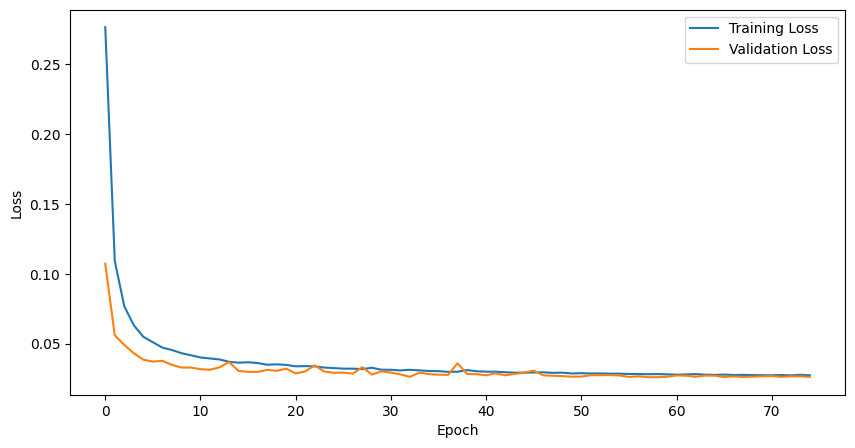

In [202]:
scratch_model = UNet(
    down_filters=[64, 128, 256, 256], 
    in_channels=1, 
    num_layers=1, 
    has_attention=[False, True, False, False], 
    num_heads=4, 
    diffusion_steps=1000,
    dropout=0.1,
    activation=nn.SiLU
).to(device)

num_params = count_parameters(scratch_model)
print(f"The UNet model has {num_params:,} trainable parameters.")

epochs = 75
lr = 3e-3

optim = torch.optim.Adam(scratch_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=lr, steps_per_epoch=len(train_dl), epochs=epochs)
loss_fn = nn.MSELoss()

beta_schedule = torch.linspace(0.0001, 0.02, 1000, requires_grad=False).to(device)

train_model(
    model=scratch_model, 
    optim=optim, 
    loss_fn=loss_fn, 
    loaders={'train': train_dl, 'valid': valid_dl}, 
    beta_schedule=beta_schedule, 
    epochs=epochs, 
    valid_every=1,
    checkpoint_every=7,
    scheduler=scheduler,
    checkpoint_dir='checkpoints',
    T=1000,
)

In [203]:
def sample_images(
        model, 
        beta_schedule, 
        T, 
        device, 
        num_samples=16, 
        in_channels=1, 
        using_diffusers: bool = False
        ):
    model.eval()
    with torch.no_grad():
        x = torch.randn(num_samples, in_channels, 32, 32).to(device)
        alpha = 1. - beta_schedule
        alpha_bar = get_alpha_bar(beta_schedule)

        for t in reversed(range(T)):
            time_input = torch.full((num_samples,), t, device=device)
            beta_t = beta_schedule[t]
            sigma_t = beta_t.sqrt()

            alpha_t = alpha[t] if t > 0 else torch.tensor(1.0)
            alpha_bar_t = alpha_bar[t]
            
            alpha_bar_t = alpha_bar[t]
            z = torch.randn_like(x).to(device) if t > 0 else torch.zeros_like(x).to(device)
            
            if using_diffusers:
                model_pred = model(x, time_input).sample
            else:
                model_pred = model(x, time_input)
            
            if t > 0:
                x_t_minus_1 = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_bar_t).sqrt() * model_pred).clamp(-1, 1) + sigma_t * z
            else:
                x_t_minus_1 = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_bar_t).sqrt() * model_pred).clamp(-1, 1)
            
            x = x_t_minus_1

    return x

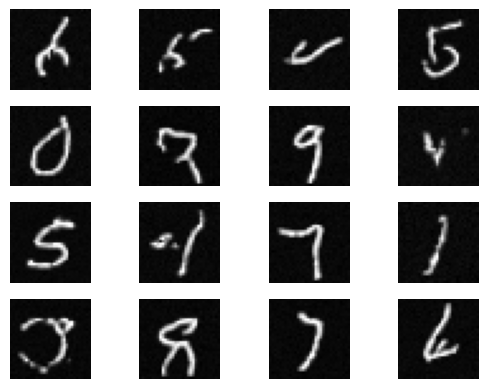

In [204]:
sampled_images = sample_images(scratch_model, beta_schedule, 1000, device, num_samples=16)
sampled_images_cpu = sampled_images.cpu()
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(sampled_images_cpu[i].squeeze().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

In [205]:
from torchvision.models import inception_v3
from torch.nn import functional as F
import numpy as np
from numpy import linalg

inception = inception_v3(pretrained=True, transform_input=False).to(device).eval()

def get_features(
        images: torch.Tensor, 
        inception: nn.Module, 
        device: torch.device, 
        batch_size: int = 50
        ) -> np.ndarray:
    features = []
    for i in range(0, images.shape[0], batch_size):
        batch = images[i:i+batch_size].to(device)
        
        with torch.no_grad():
            feat = inception(F.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False))
        
        features.append(feat.cpu().numpy())
    
    return np.concatenate(features) 

def calculate_fid(real_images, inception, gen_fn, num_gen, batch_size=50, device='cpu'):
    
    real_features = get_features(real_images, inception, device, batch_size)
    gen_features = get_features(gen_fn(num_gen), inception, device, batch_size)
    
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = gen_features.mean(axis=0), np.cov(gen_features, rowvar=False)
    
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

/Users/apandya/computer_vision/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/apandya/computer_vision/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
